In [2]:
import pandas as pd
from sklearn.preprocessing import MaxAbsScaler, LabelEncoder
label_encoder = LabelEncoder()
import json

In [5]:
baredf = pd.read_csv("../../../data/clean_nslkdd.csv", names=dataList, header=None, index_col=False)

In [82]:
x = baredf.drop(columns=[41])
y=baredf[41]

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, accuracy_score, confusion_matrix, ConfusionMatrixDisplay classification_report, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [84]:
treinoX, testeX, treinoY, testey = train_test_split(x, y, train_size=0.7, random_state=42)

In [86]:
def benchmark_modelos(modelos, X_train, y_train, X_test, y_test):
    resultados = []

    for nome, modelo in modelos.items():
        print(f"Treinando {nome}...")

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', clone(modelo))
        ])

        start = time.time()
        pipeline.fit(X_train, y_train)
        treina_duracao = time.time() - start

        start = time.time()
        y_pred = pipeline.predict(X_test)
        pred_duracao = time.time() - start

        acc = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        try:
            proba = pipeline.predict_proba(X_test)[:, 1]
            roc = roc_auc_score(y_test, proba)
        except:
            roc = None

        resultados.append({
            'Modelo': nome,
            'Acurácia': acc,
            'ROC AUC': roc,
            'Tempo Treino (s)': round(treina_duracao, 4),
            'Tempo Predição (s)': round(pred_duracao, 4),
            'Tempo por Amostra (ms)': round((pred_duracao / len(X_test)) * 1000, 4),
            'Matriz de Confusão': cm
        })

    return pd.DataFrame(resultados)


In [87]:
X = baredf.iloc[:, :-1]
y = baredf.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

In [88]:
modelos = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'RandomForest': RandomForestClassifier(n_estimators=100),
    'ExtraTrees': ExtraTreesClassifier(n_estimators=100, criterion='entropy'),
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'SVM': SVC(probability=True),
    'DecisionTree': DecisionTreeClassifier()
}


In [94]:
from tabulate import tabulate

In [96]:
df_resultados = benchmark_modelos(modelos, X_train, y_train, X_test, y_test) 

Treinando KNN...
Treinando RandomForest...
Treinando ExtraTrees...
Treinando LogisticRegression...
Treinando SVM...
Treinando DecisionTree...


In [102]:
print(tabulate(df_resultados, headers=list(df_resultados.keys()), tablefmt="fancy_grid"))
# print(df_resultados[['Modelo', 'Acurácia', 'ROC AUC', 'Tempo por Amostra (ms)', 'Tempo Treino (s)']])

╒════╤════════════════════╤════════════╤═══════════╤════════════════════╤══════════════════════╤══════════════════════════╤══════════════════════╕
│    │ Modelo             │   Acurácia │   ROC AUC │   Tempo Treino (s) │   Tempo Predição (s) │   Tempo por Amostra (ms) │ Matriz de Confusão   │
╞════╪════════════════════╪════════════╪═══════════╪════════════════════╪══════════════════════╪══════════════════════════╪══════════════════════╡
│  0 │ KNN                │   0.994567 │  0.999146 │             0.2682 │              10.7019 │                   0.3567 │ [[14867    78]       │
│    │                    │            │           │                    │                      │                          │  [   85 14970]]      │
├────┼────────────────────┼────────────┼───────────┼────────────────────┼──────────────────────┼──────────────────────────┼──────────────────────┤
│  1 │ RandomForest       │   0.998667 │  0.999991 │             7.6414 │               0.274  │                   0.0

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, RocCurveDisplay,
    classification_report,
    accuracy_score, f1_score, roc_auc_score,
    precision_score, recall_score,
    precision_recall_curve
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
import os

def avaliar_modelos(modelos, X_train, X_test, y_train, y_test, class_names=None, salvar_em=None):
    if salvar_em:
        os.makedirs(salvar_em, exist_ok=True)

    for nome, modelo in modelos.items():
        print(f"\n Avaliando modelo: {nome}")

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', clone(modelo))
        ])

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        try:
            y_score = pipeline.predict_proba(X_test)[:, 1]
        except:
            y_score = None

        # Métricas
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, pos_label=1)
        prec = precision_score(y_test, y_pred, pos_label=1)
        rec = recall_score(y_test, y_pred, pos_label=1)
        roc = roc_auc_score(y_test, y_score) if y_score is not None else 'N/A'
        cm = confusion_matrix(y_test, y_pred)
        tn, fp = cm[0]
        fn, tp = cm[1]
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

        print(f"fpr: {fpr:.4f}")
        print(f"Accuracy: {acc:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall: {rec:.4f}")
        print(f"ROC AUC: {roc if isinstance(roc, str) else round(roc, 4)}")
        print(classification_report(y_test, y_pred, target_names=class_names))

        # Criar figura com 3 plots (se ROC possível)
        ncols = 3 if y_score is not None else 1
        fig, axes = plt.subplots(1, ncols, figsize=(6 * ncols, 4))
        fig.suptitle(f"Métricas para {nome}", fontsize=16)

        ConfusionMatrixDisplay(cm, display_labels=class_names).plot(ax=axes[0] if ncols > 1 else axes)
        if ncols > 1:
            axes[0].set_title("Matriz de Confusão")
        else:
            axes.set_title("Matriz de Confusão")

        # Curva ROC
        if y_score is not None:
            fpr, tpr, _ = roc_curve(y_test, y_score)
            RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=axes[1])
            axes[1].set_title("Curva ROC")

            # Curva Precision-Recall
            precision, recall, _ = precision_recall_curve(y_test, y_score)
            axes[2].plot(recall, precision, label="PR Curve")
            axes[2].set_title("Curva Precision-Recall")
            axes[2].set_xlabel("Recall")
            axes[2].set_ylabel("Precision")
            # axes[2].legend()

        plt.tight_layout()

        # Salvar se necessário
        if salvar_em:
            caminho = os.path.join(salvar_em, f"{nome}_metricas.png")
            plt.savefig(caminho)
            print(f"Gráfico salvo em: {caminho}")

        plt.show()



 Avaliando modelo: KNN
Accuracy: 0.9946
F1 Score: 0.9946
Precision: 0.9948
Recall: 0.9944
ROC AUC: 0.9991
              precision    recall  f1-score   support

      normal       0.99      0.99      0.99     14945
     anomaly       0.99      0.99      0.99     15055

    accuracy                           0.99     30000
   macro avg       0.99      0.99      0.99     30000
weighted avg       0.99      0.99      0.99     30000

fpr: 0.0052


/home/luizp/projects/puc/tcc/venv/lib64/python3.13/site-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


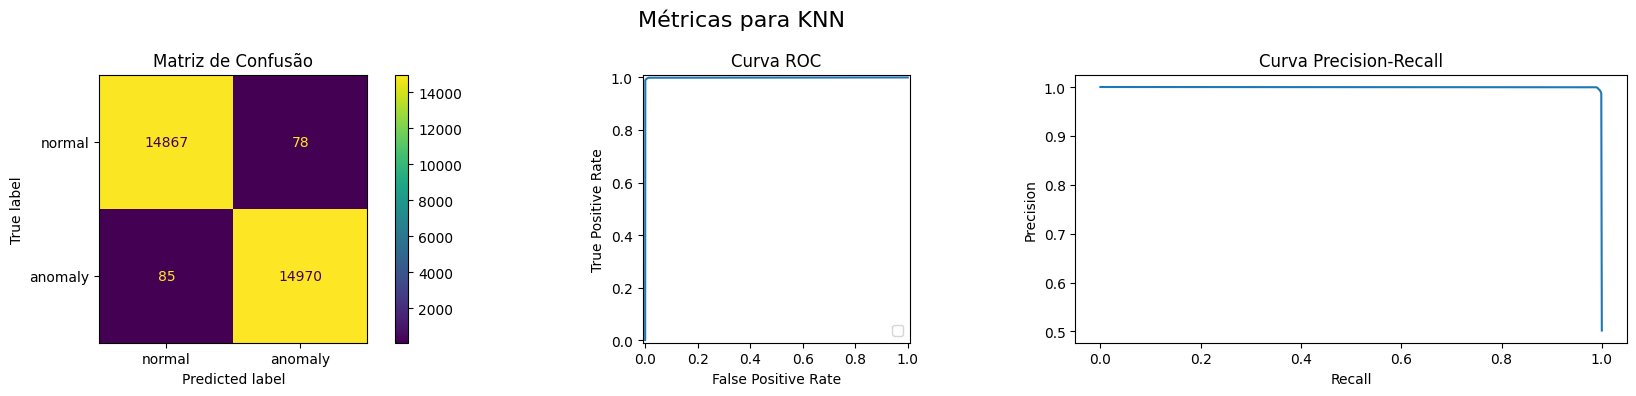


 Avaliando modelo: RandomForest
Accuracy: 0.9986
F1 Score: 0.9986
Precision: 0.9994
Recall: 0.9979
ROC AUC: 1.0
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00     14945
     anomaly       1.00      1.00      1.00     15055

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000

fpr: 0.0006


/home/luizp/projects/puc/tcc/venv/lib64/python3.13/site-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


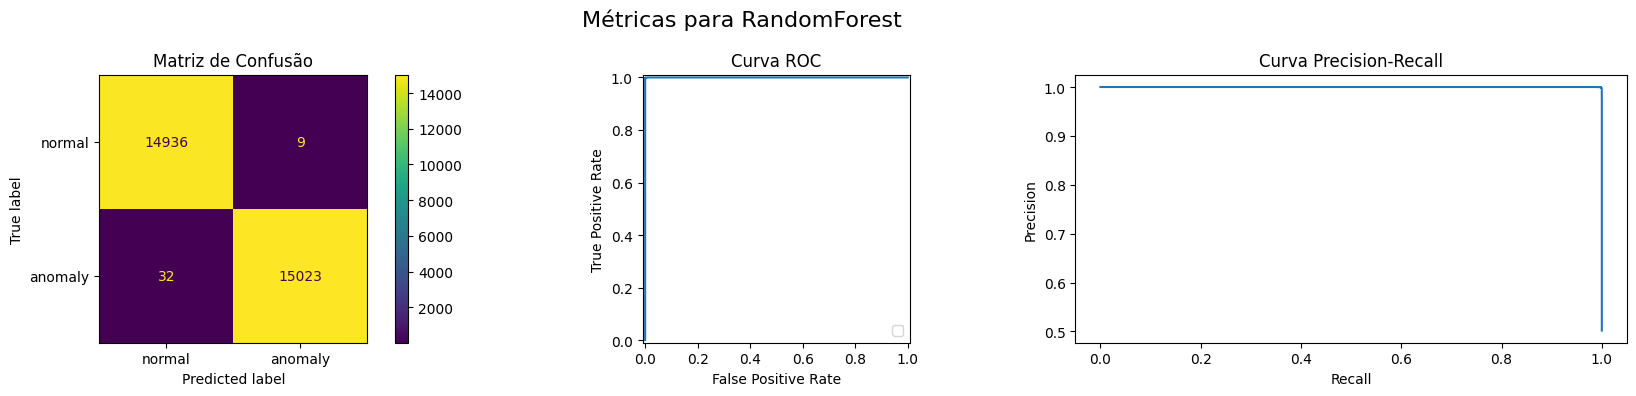


 Avaliando modelo: ExtraTrees
Accuracy: 0.9983
F1 Score: 0.9983
Precision: 0.9994
Recall: 0.9973
ROC AUC: 0.9999
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00     14945
     anomaly       1.00      1.00      1.00     15055

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000

fpr: 0.0006


/home/luizp/projects/puc/tcc/venv/lib64/python3.13/site-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


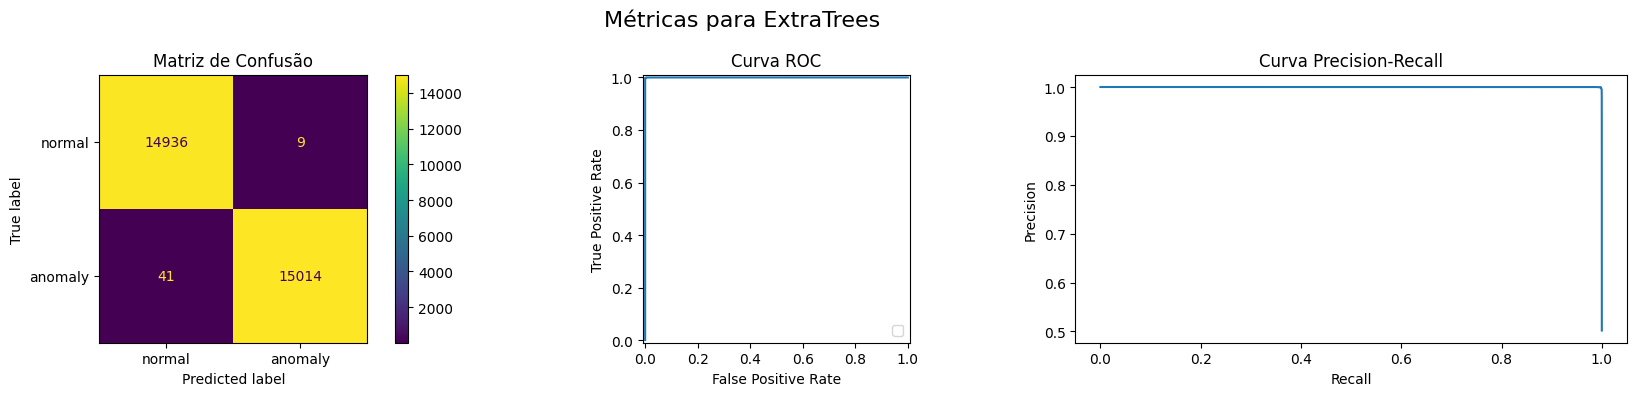


 Avaliando modelo: LogisticRegression
Accuracy: 0.9553
F1 Score: 0.9551
Precision: 0.9630
Recall: 0.9473
ROC AUC: 0.9919
              precision    recall  f1-score   support

      normal       0.95      0.96      0.96     14945
     anomaly       0.96      0.95      0.96     15055

    accuracy                           0.96     30000
   macro avg       0.96      0.96      0.96     30000
weighted avg       0.96      0.96      0.96     30000

fpr: 0.0367


/home/luizp/projects/puc/tcc/venv/lib64/python3.13/site-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


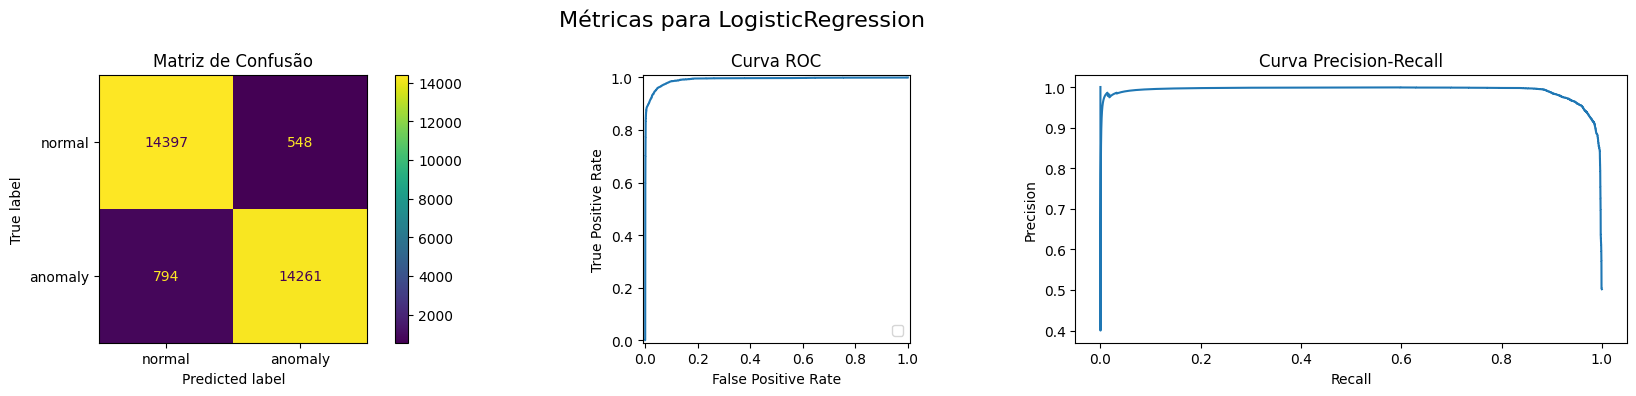


 Avaliando modelo: SVM


In [ ]:
metricas = avaliar_modelos(modelos, treinoX, testeX, treinoY, testey, class_names=['normal', 'anomaly'])
